In [1]:
import tensorflow as tf
from Functions import *
import pyautogui 
import matplotlib.pyplot as plt
import itertools
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Loading in Dataset

In [12]:
filename = 'fer2013.csv'
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names)
df = df.iloc[1:]
df.head(10)
picdict = pkl.load(open('picdict2.pkl','rb'))
visx = []
visy = []
for label, pic in picdict.items():
  visx.append(pic)
  visy.append(label)

In [3]:
#Im gonna make the same df but with the actual labels instead of 0-6
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
pixls = df['pixels']
label_series = df['emotion']
#replacing each class with its corresponding label by indexing label_map with the class 
label_series=label_series.apply(lambda emotion_class: label_map[int(emotion_class)])
verbaldf = pd.DataFrame()
verbaldf['pixels']=df['pixels']
verbaldf['emotion'] = label_series
verbaldf.head(10)




,pixels,emotion
1,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Anger
2,151 150 147 155 148 133 111 140 170 174 182 15...,Anger
3,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
5,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral
6,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Fear
7,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Sad
8,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Happy
9,85 84 90 121 101 102 133 153 153 169 177 189 1...,Happy
10,255 254 255 254 254 179 122 107 95 124 149 150...,Fear


### Checking Out Our Class Imbalance

In [4]:
def picfromdf(df,index):
    ''' takes in the image dataframe and and an boservations index location 
    and parses the pixel string and returns the 48,48 image that that string was meant to convey,
    also displays the image '''
    arr = df['pixels'].iloc[index]
    arr = arr.split(' ')
    ans = []
    for i in arr:
        ans.append(int(i))
    return np.array(ans).reshape(48,48)
def genpicdict(df):
    '''To be able to get examples of each picture I made a function that 
    takes in the dataframe and parses it for a picture in 
    each of the classes then it returns a dictionary of those pictures'''
    picdict = {}
    for i in ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']:
        if i not in picdict:
            picdict[i] = picfromdf(df[df['emotion'] == i],1)
    return picdict


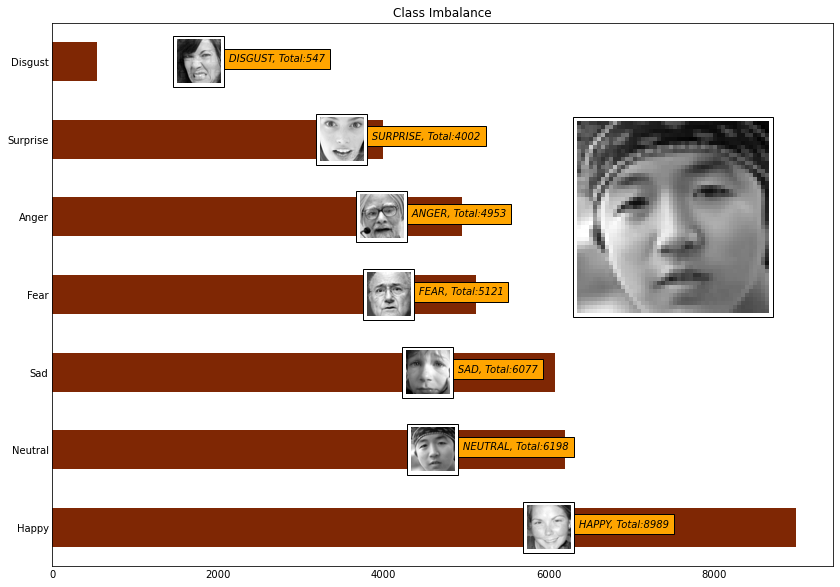

In [5]:
picdict = genpicdict(verbaldf)

ax =  verbaldf['emotion'].value_counts().plot.barh(cmap='Oranges_r',figsize=(14,10))

val_counts = list(verbaldf['emotion'].value_counts().items())

# ax.axis([0, 128, 0, 256])

ax.set_title('Class Imbalance')

ycoord = 0
for tup in val_counts:
    label, count = tup
    spaces = ' '*15
    ax.text(((count/2) -200)+1500, ycoord, f'{spaces}{label.upper()}, Total:{count}', style='italic',
        bbox={'facecolor': 'orange', 'alpha': 1.00, 'pad': 5})
    
    imagebox = OffsetImage(picdict[label], zoom=0.9,cmap='gray')
    ab = AnnotationBbox(imagebox, ((count/2)+1500, ycoord))

    ax.add_artist(ab)

   

    ycoord+=1
ax.tick_params(axis=u'both', which=u'both',length=0)
imagebox = OffsetImage(picdict['Neutral'], zoom=4.0,cmap='gray')
ab = AnnotationBbox(imagebox, (7500, 4))

ax.add_artist(ab)

plt.draw()




The classes are slightly unbalanced and but this didnt seem to hurt anything. Disgust is the one real problem case but from what ive seen the images are very different compared to the other pictures and alot of the models I ran didnt have trouble with it.

## Preparing Data
At this point I dont need to do anything extra to the data besides one hot encoding the labels, turing the dataframe into a tensor, and doing a train test split. 

In [6]:
#split the csv into the x and y so we can do a train test split
X, Y = getData(filename)
num_class = len(set(Y))


In [7]:
N, D = X.shape
X = X.reshape(N, 48, 48, 1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)
Y = (np.arange(num_class) == Y[:, None]).astype(np.float32)

## Modeling Process
For the sake of this notebooks readability im only going to go over the first, fifth, and final models in this notebook all ten are in my modeling notebook: https://github.com/AmirMEdris/Emotion-classification-from-facial-expression/blob/main/Modeling.ipynb

### Initial model 
#### The first model wasn't made by me, the architecture and weights came from the kaggle user Ashadullah Shawon, his notebook: https://www.kaggle.com/shawon10/facial-expression-detection-cnn

When I first started this project I focused a little too hard on what I would be able to do with a trained model and because of that I used a model that had already done good on the kaggle page for this data. 

In [10]:
Ashadullah_model = Sequential()
input_shape = (48,48,1)
Ashadullah_model.add(Conv2D(64, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
Ashadullah_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
Ashadullah_model.add(Conv2D(128, (5, 5),activation='relu',padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
Ashadullah_model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(MaxPooling2D(pool_size=(2, 2)))

Ashadullah_model.add(Flatten())
Ashadullah_model.add(Dense(128))
Ashadullah_model.add(BatchNormalization())
Ashadullah_model.add(Activation('relu'))
Ashadullah_model.add(Dropout(0.2))
Ashadullah_model.add(Dense(7))
Ashadullah_model.add(Activation('softmax'))

Ashadullah_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
Ashadullah_model.load_weights('firstmodel')



['conv2d_6', 'conv2d_7', 'max_pooling2d_3', 'conv2d_8', 'conv2d_9', 'max_pooling2d_4', 'conv2d_10', 'conv2d_11', 'max_pooling2d_5']


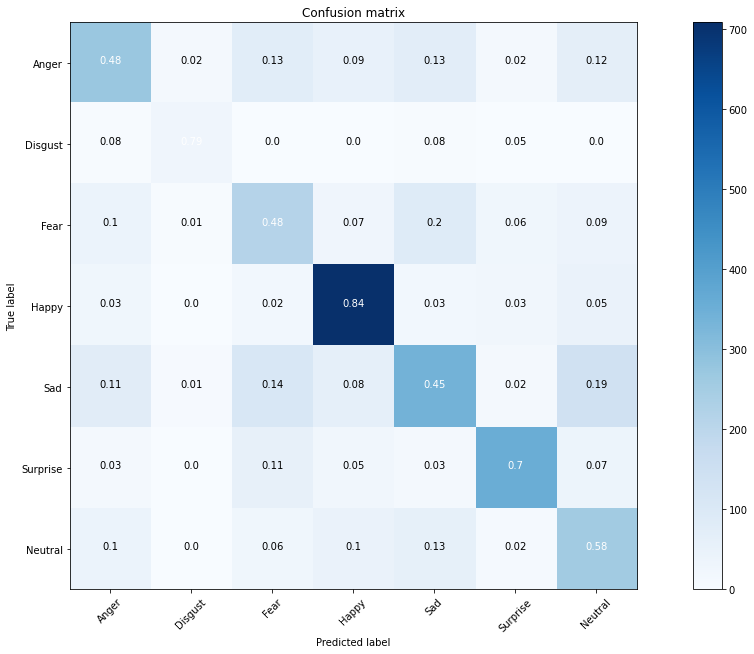

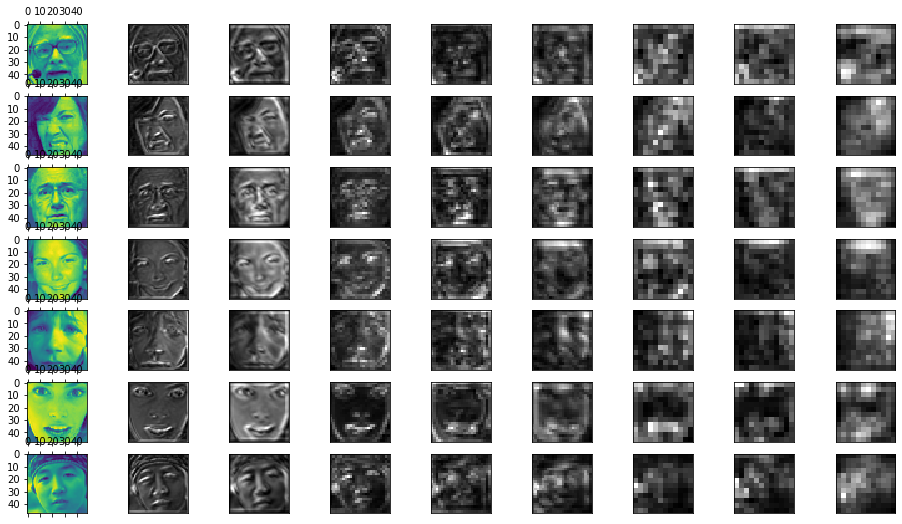

In [13]:
model_eval(Ashadullah_model,X_test,y_test,label_map,visx,visy)


This model had a 57% f1 on the validation set, when I went throug and visualized the differnt activations for this model on some different images and alot of times it would care more about the eye region of a person even if it detected a clear smile which would be fine if the model accuratly extracted eye features but it often didnt and would often get thrown off buy things like bushy eyebrows. This among other things, like moving to google cloud and cutting down my modeling time by a factor of 30, led me to try make the model deeper. At first I was just tweaking the parameters of Ashadullah's model like removing some of the dropout layers to see their overall effect and messing with the distribution of the conv layers. Also I havent taken the time to speak about why I chose f1 and its mostly because I wanted to thing of every class as diferent, there wasnt one specific case that I was targeting.

### Model 4
I chose this model because I thought the layer outputs more closely resembled what I wanted the model too be looking for. I was exporementing with the effects of conv layers right after each other. At this point I was more focused on the conv layers rather than the dense layers.

In [14]:
model4 = Sequential()
input_shape = (48,48,1)
model4.add(Conv2D(64, (2, 2), input_shape=input_shape,activation='relu', padding='same'))
model4.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
model4.add(Conv2D(64, (5, 5),activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(128, (2, 2),activation='relu',padding='same'))
model4.add(Conv2D(128, (4, 4),activation='relu',padding='same'))
model4.add(Conv2D(128, (2, 2),activation='relu',padding='same'))

model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2, 2)))


model4.add(Flatten())



model4.add(Activation('relu'))
model4.add(Dense(250))

model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dense(64))
model4.add(Activation('relu'))
model4.add(Dense(7))
model4.add(Activation('softmax'))

model4.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
model4.load_weights('model4')

['conv2d_12', 'conv2d_13', 'conv2d_14', 'max_pooling2d_6', 'conv2d_15', 'conv2d_16', 'conv2d_17', 'max_pooling2d_7']


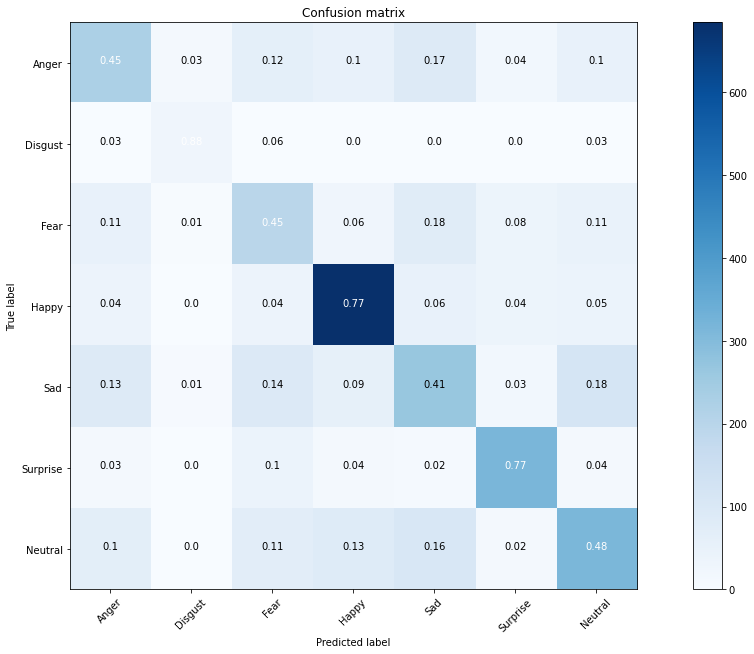

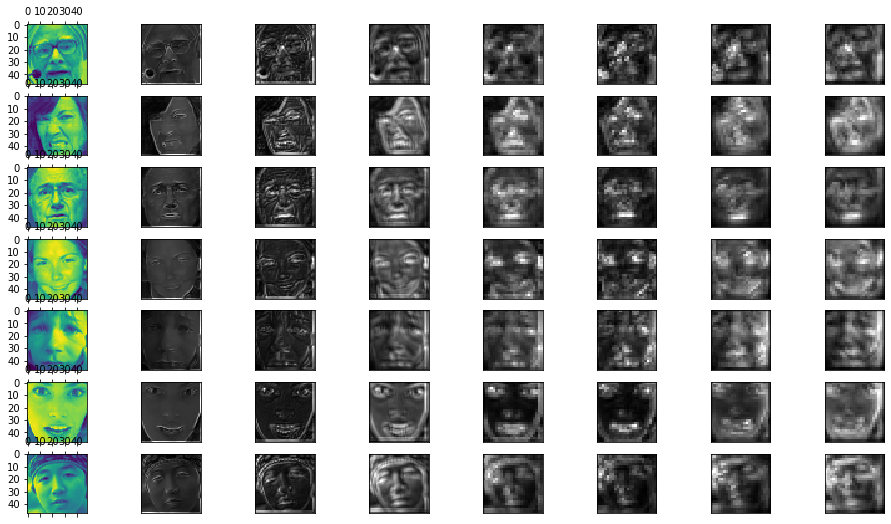

In [15]:
model_eval(model4,X_test,y_test,label_map,visx,visy)

### Final Model
In my modeling notebook I went through 10 different models where in each I tried to focus on a different aspect and I used the validation set and the avg layer activations to decide what to bring into this final model. Many of the previous models struggled with acurately finding the persons mouth so I went to the model that did that the best and took the layer that produced that activation and added it here(specifically the Conv2D(256, (5, 5) and Conv2D(512, (4, 4). Overall I found that aside from finding the mouth big filter layers werent very helpful probably because of the 48,48 image size because of this I mainly used 2,2 conv layers. of all the model none could reach 65%+ f1 without overfitting so to combat this I added dropout to each layer. I also only used max pooling 2 times and made the dense layers thicker and wider because I felt that too much information was being lost in the image by the time I was getting to the dense layer in other models.

In [16]:
final_model = Sequential()
input_shape = (48,48,1)
final_model.add(Conv2D(256, (2, 2), input_shape=input_shape,activation='relu', padding='same'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Conv2D(256, (2, 2), input_shape=input_shape,activation='relu', padding='same'))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.2))

final_model.add(Conv2D(256, (5, 5), input_shape=input_shape,activation='relu', padding='same'))
final_model.add(Dropout(0.2))

final_model.add(BatchNormalization())
final_model.add(MaxPooling2D(pool_size=(2, 2)))

final_model.add(Conv2D(512, (2, 2),activation='relu',padding='same'))
final_model.add(Dropout(0.2))

final_model.add(BatchNormalization())

final_model.add(Conv2D(512, (4, 4),activation='relu',padding='same'))
final_model.add(Dropout(0.2))

final_model.add(BatchNormalization())

final_model.add(Conv2D(512, (2, 2),activation='relu',padding='same'))
final_model.add(Dropout(0.2))


final_model.add(BatchNormalization())
final_model.add(MaxPooling2D(pool_size=(2, 2)))


final_model.add(Flatten())
final_model.add(Dense(750))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.3))

final_model.add(Dense(750))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.3))

final_model.add(Dense(750))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.3))

final_model.add(Activation('relu'))
final_model.add(Dense(250))
final_model.add(Dropout(0.2))

final_model.add(BatchNormalization())
final_model.add(Activation('relu'))
final_model.add(Dense(64))
final_model.add(Activation('relu'))
final_model.add(Dense(7))
final_model.add(Activation('softmax'))

final_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

final_model.load_weights('FinalModel')

In [ ]:
model_eval(final_model,X_test,y_test,label_map,visx,visy)

In [ ]:
#test it on a picture and use visualiztaions to see what the model sees
base_model = final_model
names = [name.name for name in  base_model.layers]
layers = [base_model.get_layer(name).output for name in names[:-1]]
# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
base_model1 = Ashadullah_model
names1 = [name.name for name in  base_model1.layers]
layers1 = [base_model1.get_layer(name).output for name in names1[:-1]]
# Create the feature extraction model
dream_model1 = tf.keras.Model(inputs=base_model1.input, outputs=layers1)
base_model2 = model5
names2 = [name.name for name in  base_model2.layers]
layers2 = [base_model2.get_layer(name).output for name in names2[:-1]]
# Create the feature extraction model
dream_model2 = tf.keras.Model(inputs=base_model2.input, outputs=layers2)
pickedpic= prep_image(pics[0])
for pic in pickedpic:
    pic=pic.reshape(1,48,48,1)
    plt.matshow(pic[0,:,:,0],cmap='gray')
    prediction = dream_model.predict(pic)
    fig, ax = plt.subplots(1,8,figsize=(16,12))

    for i in range(len(prediction[:8])):
        for layer in prediction[i]:
            newlayer=[]
            for line in layer:
                newline = []
                for pixel in line:
                    newpix = 0
                    for value in pixel:
                        newpix+=value
                    newpix = value
                    newline.append(newpix)
                newlayer.append(newline)
            ax[i].matshow(newlayer,cmap='gray')
            ax[i].grid(False)

    # Hide axes ticks
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    # plt.matshow(pickedpic[0,:,:,0],cmap='gray')
    plt.tight_layout()



    prediction = dream_model2.predict(pic)
    fig, ax = plt.subplots(1,8,figsize=(16,12))

    for i in range(len(prediction[:8])):
        for layer in prediction[i]:
            newlayer=[]
            for line in layer:
                newline = []
                for pixel in line:
                    newpix = 0
                    for value in pixel:
                        newpix+=value/len(pixel)
                    newpix = abs(newpix)
                    newline.append(newpix)
                newlayer.append(newline)
            ax[i].matshow(newlayer,cmap='gray')
            ax[i].grid(False)

    # Hide axes ticks
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    prediction = dream_model1.predict(pic)
    fig, ax = plt.subplots(1,8,figsize=(16,12))
    for i in range(len(prediction[:8])):
        for layer in prediction[i]:
            newlayer=[]
            for line in layer:
                newline = []
                for pixel in line:
                    newpix = 0
                    for value in pixel:
                        newpix+=value
                    newpix = (newpix)
                    newline.append(newpix)
                newlayer.append(newline)
            ax[i].matshow(newlayer,cmap='gray')
            ax[i].grid(False)

    # Hide axes ticks
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()        
    print('model 1',predict_emotion(pic,Ashadullah_model))
    print('model 2',predict_emotion(pic,final_model))   
    print('model 3',predict_emotion(pic,model5))
    plt.show()
# plt.matshow(pickedpic[0,:,:,0],cmap='gray')





#do the same with youself
#explain the problem with testing it on your self
#bring in haar cascade classifier
#show the haar cascade classifier finding your face and multiple faces
#use the cascade classifier to predict on your face
#use both to predict on you face and show the visualizations
#talk about context and body language
#bring in and demonstrate pose estimator
#show video of your program predicting in realtime
#discuss failures and next steps



In [ ]:
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")
camera = 0
resize = '432x368'     # resize images before they are processed
resize_out_ratio = 4.0 # resize heatmaps before they are post-processed
mod = 'mobilenet_thin'
#tf-pose is a library built around cmu
show_process = False
tensorrt = False       # for tensorrt process
# logger.debug('initialization %s : %s' % (args.model, get_graph_path(args.model)))
w, h = model_wh(resize)

e = TfPoseEstimator(get_graph_path(mod), target_size=(432, 368), trt_bool=False)
# humans = e.inference(image,
#                          resize_to_default=(w > 0 and h > 0),
#                          upsample_size=resize_out_ratio)

#     #logger.debug('postprocess+')
#     image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
from IPython.display import clear_output
clear_output()

In [ ]:
#loading in haar cascade classifier to be able to locate and crop faces
cascade = load_cascade_classifier_xml()

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    raise IOError("Cannot open webcam")
sfps = 0
  
fps = 0
pics = []
#params for different togle settings
showfps=1
predicting = -1
pose = -1
tips = 1
showscreen = -1

while True:
    if showscreen == 1:#check if we are suppoused to taking input from camera or screen 
        if cap.isOpened():
            cap.release()
        img = pyautogui.screenshot()
        frame = np.array(img)[900:,:1000]#if we are taking input from the screen we crop it to be more manageble
        baseframe = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if showscreen == -1:
        if not cap.isOpened():
            cap = cv2.VideoCapture(0)
        ret, frame = cap.read()
        baseframe = frame
    

    #use our find faces in img function that takes in haar cascade classifier and a frame then returns 
    #the frame with boxes around the heads of people, the coordinates of faces, and the faces
    coords,faces,faceframe = find_faces_in_img(baseframe,cascade)
    if predicting == 1:
        for i in range(0,len(faces)):
            face = faces[i]
            frame = prep_image(face)

            prediction = predict_emotion(frame,final_model)

            text = 'Prediction = '+str(prediction)
            maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
    if pose ==1:
        #using pose estimation from tf-pose library based on the cmu pose estimator
        humans = e.inference(baseframe,
                             resize_to_default=(w > 0 and h > 0),
                             upsample_size=resize_out_ratio)
        image = TfPoseEstimator.draw_humans(baseframe, humans, imgcopy=False)
    fps=time()
    FPS=1/(fps-sfps)
    sfps = fps
    FPS = 'FPS:'+str(round(FPS,ndigits=3))+' & We Found '+str(len(faces))+ ' Face(s)!'
    
    if showfps == 1:
        maketextaboveface(baseframe,FPS,(10,70))
        
    if tips == 1:
        maketextaboveface(baseframe,'press p to predict emotion on detected faces',(10,140))
        maketextaboveface(baseframe,'press e to detect poses',(10,210))
        maketextaboveface(baseframe,'press SPACE to save face',(10,280))
        maketextaboveface(baseframe,'press ESC to exit, i to toggle tips, and f to toggle fps',(10,350))
        
    cv2.imshow('feed', baseframe)
    
    #at the end of a frame check if a button was pressed
    c = cv2.waitKey(50)
    if c == 32:
        coords,faces,faceframe = find_faces_in_img(baseframe,cascade)

        for i in range(0,len(faces)):
            
            face = faces[i]
            frame = prep_image(face)

            prediction = predict_emotion(frame,final_model)

            text = 'Prediction = '+str(prediction)
            maketextaboveface(baseframe,text,(coords[i][2],coords[i][0]))
            cv2.imshow(f'face{i}', face)
            pics.append(face)
    if c == 112:
        predicting*=-1
    if c == 102:
        showfps*=-1
    if c == 105:
        tips*=-1
    if c == 101:
        pose*=-1
    if c == 97:
        showscreen*=-1
    if c == 27:
        break
cv2.destroyAllWindows()
cap.release()


In [ ]:
pkl.dump(pics,open('myface.pkl','wb'))